In [1]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.axes_grid1 import make_axes_locatable
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import root_mean_squared_error
from astropy.constants import c, e, m_e
from astropy import units as u
from tqdm import tqdm
import os
import sys
sys.path.append("../")
from modules.model_prof_tools import read_prof


In [2]:
def create_data_cube_animation(data_cube, cmap='gist_gray', interval=500, 
                              title_format='Layer {} of {}', figsize=(7, 4),
                              colorbar_label='Value'):
    """
    Create an animation of a data cube by displaying slices along the first dimension.
    
    Parameters:
    -----------
    data_cube : numpy.ndarray
        3D data cube to animate
    cmap : str, optional
        Matplotlib colormap name (default: 'gist_gray')
    interval : int, optional
        Animation interval in milliseconds (default: 500)
    title_format : str, optional
        Format string for the title, should contain two placeholders for current and max index
    figsize : tuple, optional
        Figure size (width, height) in inches
    colorbar_label : str, optional
        Label for the colorbar
        
    Returns:
    --------
    IPython.display.HTML
        HTML animation that can be displayed in the notebook
    """
    fig, ax = plt.subplots(figsize=figsize)

    # Find min and max values for consistent colormap scaling
    vmin = data_cube.min()
    vmax = data_cube.max()

    # Initial plot
    im = ax.imshow(data_cube[0], cmap=cmap, vmin=vmin, vmax=vmax)

    # Create proper sized colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="2%", pad=0.05)
    cbar = fig.colorbar(im, cax=cax)
    cbar.set_label(colorbar_label)

    # Set title with more information
    title = ax.set_title(title_format.format(0, data_cube.shape[0]-1))

    # Update function for animation
    def update(frame):
        im.set_array(data_cube[frame])
        title.set_text(title_format.format(frame, data_cube.shape[0]-1))
        return [im, title]

    # Create animation
    anim = FuncAnimation(fig, update, frames=data_cube.shape[0], 
                         interval=interval, blit=True)

    # Add tight layout to make better use of space
    plt.tight_layout()

    # Display animation in notebook with controls
    return HTML(anim.to_jshtml())

### $B_{\text{LOS}}$ function from stokes $V$

The weak field approximation is given as
\begin{equation}
    V \approx -\frac{e}{4\pi m_e c} \cdot \lambda_0^2 \cdot g_{\lambda_0} \cdot B_{\text{LOS}} \frac{dI}{dl}
\end{equation}

In [3]:
def B_LOS_from_stokes(stokes:np.ndarray,
                      ll:np.ndarray,
                      start_ll:int,
                      end_ll:int,
                      llambda0:float,
                      g:float,
                      stokes_v_index:int):
    """
    Estimate the line-of-sight magnetic field from a data cube of Stokes I profiles.
    Args:
    stokes: numpy.ndarray
        3D data cube of Stokes I profiles
    ll: numpy.ndarray
        Wavelength axis in amstrongs
    start_ll: int
        Index of the starting wavelength range
    end_ll: int
        Index of the ending wavelength range
    llambda0: float
        Rest wavelength in amstrongs
    g: float
        Landé factor
    stokes_v_index: int
        Index of the Stokes V profile in the data cube
    Returns:
    numpy.ndarray
        2D map of the line-of-sight magnetic field in Gauss
    """
    wfa_constant = e.si / (4 * np.pi) / m_e / c
    wfa_constant = wfa_constant.to(1 / u.G / u.Angstrom )
    def estimate_B(dI_dl, V):
        ND = len(V)
        a = np.zeros([ND, 2])
        a[:, 0] = dI_dl[:]
        a[:, 1] = 1.0
        b = V[:]

        # Correct least-squares solution
        p = np.linalg.pinv(a) @ b / dI_dl.unit
        
        # Compute B_LOS
        B = -p[0]*u.Angstrom / (wfa_constant * (llambda0)**2.0 * g)
        return B
        
    NX = stokes.shape[0]
    NY = stokes.shape[1]

    B = np.zeros([NX,NY])

    for i in range (0,NX):
        for j in range(0,NY):
            dI_dl =  np.gradient(stokes[i,j,0,start_ll:end_ll]) / np.gradient(ll[start_ll:end_ll])
            local_B = estimate_B(dI_dl = dI_dl,
                                V = stokes[i,j,stokes_v_index,start_ll:end_ll])
            B[i,j] = local_B.value
    B = B * u.G
    
    return B

## Sebas

In [4]:
with fits.open("../../data/hinode-MODEST/INV_560_AR11967/continuum.fits") as hdul:
    continuun = hdul[0].data

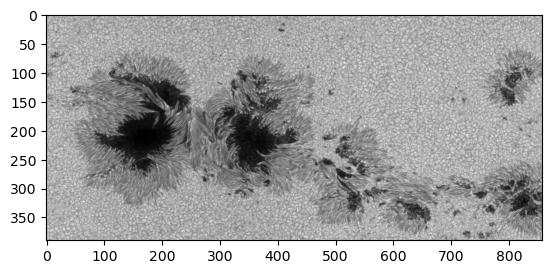

In [5]:
plt.imshow(continuun, cmap='gray')

In [6]:
with fits.open("../../data/hinode-MODEST/INV_560_AR11967/inverted_profs.1.fits") as hdul:
    inverted_profs = hdul[0].data
    invprofs_header = hdul[0].header
inverted_profs.shape

(390, 858, 4, 250)

In [7]:
invprofs_header

SIMPLE  =                    T / Written by IDL:  Wed May 12 03:25:47 2021      
BITPIX  =                  -32 / number of bits per data pixel                  
NAXIS   =                    4 / number of data axes                            
NAXIS1  =                  250 / Number of positions along axis 1               
NAXIS2  =                    4 / Number of positions along axis 2               
NAXIS3  =                  858 / Number of positions along axis 3               
NAXIS4  =                  390 / Number of positions along axis 4               
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
WLREF   =       6.30249360E+03 / reference wavelength                           
WLMIN   =      -1.62000000E+00 / min. wavelength                                
WLMAX   =       7.64000000E-

In [8]:
center_wavelength = invprofs_header['WLREF']
left_wavelength = center_wavelength + invprofs_header['WLMIN']
right_wavelength = center_wavelength + invprofs_header['WLMAX']
wl = np.linspace(left_wavelength, right_wavelength, invprofs_header['NWL'])
wl = wl * u.Angstrom
pixel_y = 8
pixel_x = 8

In [19]:
wl

<Quantity [6300.8736    , 6300.8831743 , 6300.89274859, 6300.90232289,
           6300.91189719, 6300.92147149, 6300.93104578, 6300.94062008,
           6300.95019438, 6300.95976867, 6300.96934297, 6300.97891727,
           6300.98849157, 6300.99806586, 6301.00764016, 6301.01721446,
           6301.02678876, 6301.03636305, 6301.04593735, 6301.05551165,
           6301.06508594, 6301.07466024, 6301.08423454, 6301.09380884,
           6301.10338313, 6301.11295743, 6301.12253173, 6301.13210602,
           6301.14168032, 6301.15125462, 6301.16082892, 6301.17040321,
           6301.17997751, 6301.18955181, 6301.1991261 , 6301.2087004 ,
           6301.2182747 , 6301.227849  , 6301.23742329, 6301.24699759,
           6301.25657189, 6301.26614618, 6301.27572048, 6301.28529478,
           6301.29486908, 6301.30444337, 6301.31401767, 6301.32359197,
           6301.33316627, 6301.34274056, 6301.35231486, 6301.36188916,
           6301.37146345, 6301.38103775, 6301.39061205, 6301.40018635,
      

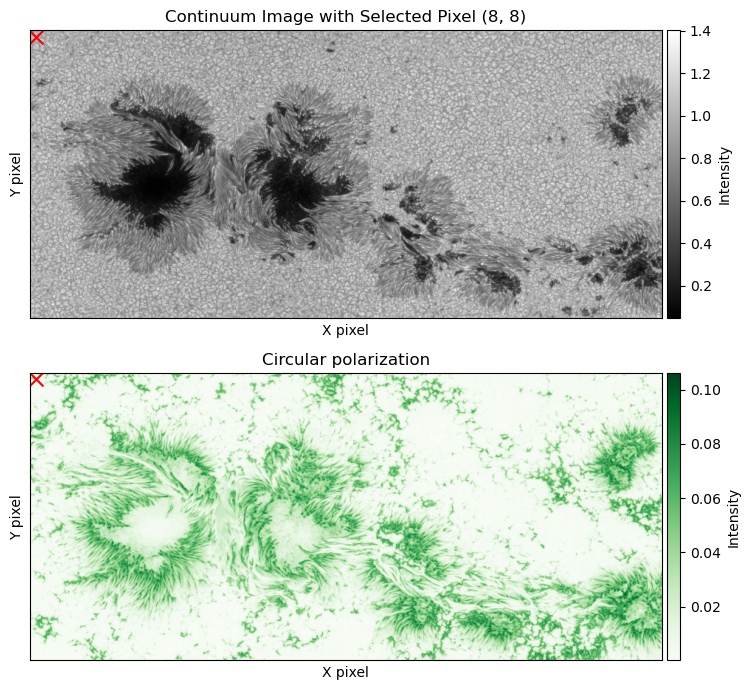

In [9]:
fig, ax = plt.subplots(2, figsize=(14*2,7))
ims = []

ims.append(ax[0].imshow(continuun, cmap='gray'))
for i in range(2):
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].scatter(pixel_x, pixel_y, color='red', marker='x', s=100)  # Mark the pixel
ax[0].set_title(f'Continuum Image with Selected Pixel ({pixel_x}, {pixel_y})')
ax[0].set_xlabel('X pixel')
ax[0].set_ylabel('Y pixel')
ax[0].grid(False)

# Fix: Display Stokes V for all pixels at wavelength index 50
circular_polarization = np.sqrt(np.sum(inverted_profs[:,:,1,:]**2.0, axis = -1)) / np.sqrt(np.sum(inverted_profs[:,:,0,:]**2.0, axis = -1)).flatten().mean()
ims.append(ax[1].imshow(circular_polarization, cmap='Greens'))
ax[1].set_title('Circular polarization')
ax[1].set_xlabel('X pixel')
ax[1].set_ylabel('Y pixel')
ax[1].grid(False)

# Create proper sized colorbar
for i in range(2):
    divider = make_axes_locatable(ax[i])
    cax = divider.append_axes("right", size="2%", pad=0.05)
    cbar = fig.colorbar(ims[i], cax=cax)
    cbar.set_label('Intensity')

plt.tight_layout()


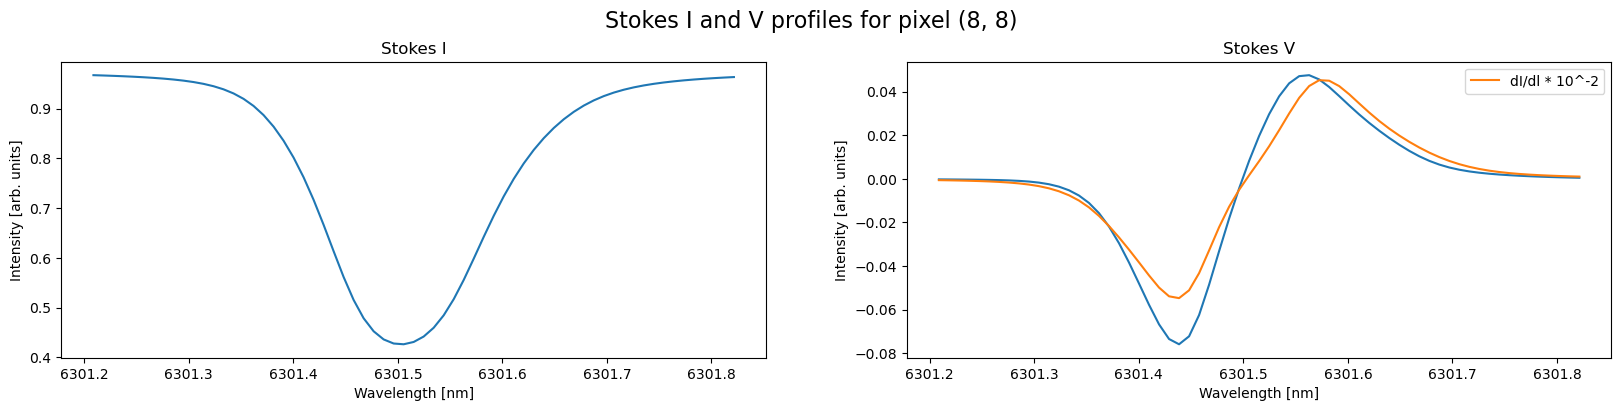

In [10]:
start_wl = 35
end_wl = 100
scale_constant = 1E-2
fig, ax = plt.subplots(1,2,figsize=(10*2,4))
# Set title for the entire figure
fig.suptitle(f'Stokes I and V profiles for pixel ({pixel_x}, {pixel_y})', fontsize=16)

# Ensure non-scientific notation for x-axis ticks
for a in ax:
    a.ticklabel_format(useOffset=False, style='plain', axis='x')
    
# Add some padding for the suptitle
plt.subplots_adjust(top=0.85)
ax[0].plot(wl[start_wl:end_wl], inverted_profs[pixel_x, pixel_y,0,start_wl:end_wl])
ax[0].set_xlabel('Wavelength [nm]')
ax[0].set_ylabel('Intensity [arb. units]')
ax[0].set_title('Stokes I')
ax[1].plot(wl[start_wl:end_wl], inverted_profs[pixel_x, pixel_y,1,start_wl:end_wl])
ax[1].set_xlabel('Wavelength [nm]')
ax[1].set_ylabel('Intensity [arb. units]')
ax[1].set_title('Stokes V')
dI_dl = np.gradient(inverted_profs[pixel_x, pixel_y,0,:]) / np.gradient(wl)
ax[1].plot(wl[start_wl:end_wl], dI_dl[start_wl:end_wl]*scale_constant, label='dI/dl * 10^-2')
ax[1].legend()
plt.show()

In [11]:
# Magnetic field from fits
with fits.open("../../data/hinode-MODEST/INV_560_AR11967/inverted_atmos.fits") as hdul:
    inverted_atm = hdul[0].data
    invatm_header = hdul[0].header
inverted_atm_B_LOS = np.multiply(inverted_atm[10], np.cos(np.deg2rad(inverted_atm[13])))

# Magnetic field from Stokes with weak field approximation
inferred_B_LOS = B_LOS_from_stokes(stokes = inverted_profs, 
                                   ll = wl, 
                                   start_ll = start_wl, 
                                   end_ll = end_wl, 
                                   llambda0 = 6301.5*u.Angstrom, 
                                   g = 1.67,
                                   stokes_v_index = 1)


In [12]:
invatm_header

SIMPLE  =                    T / Written by IDL:  Wed May 12 02:56:32 2021      
BITPIX  =                  -32 / number of bits per data pixel                  
NAXIS   =                    3 / number of data axes                            
NAXIS1  =                  858 / Number of positions along axis 1               
NAXIS2  =                  390 / Number of positions along axis 2               
NAXIS3  =                   23 / Number of positions along axis 3               
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
CODE    = 'SPINOR  '           / inversion code                                 
LTTOP   =                    1 /       0.00      0.00   0 1   0                 
LTINC   =                    2 /       0.00      0.00   0 1   0                 
LGTRF   =                   

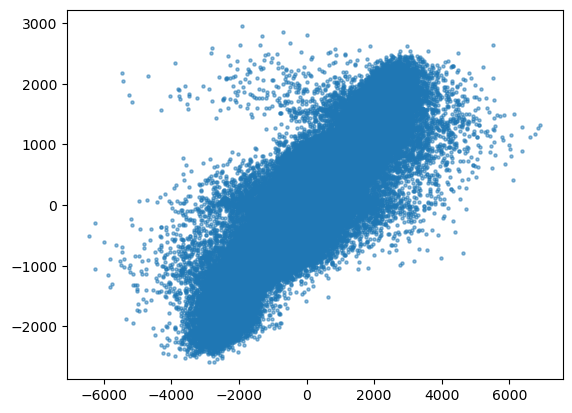

In [13]:
plt.scatter(inverted_atm_B_LOS.flatten(), inferred_B_LOS.flatten(), s = 5, alpha = 0.5)

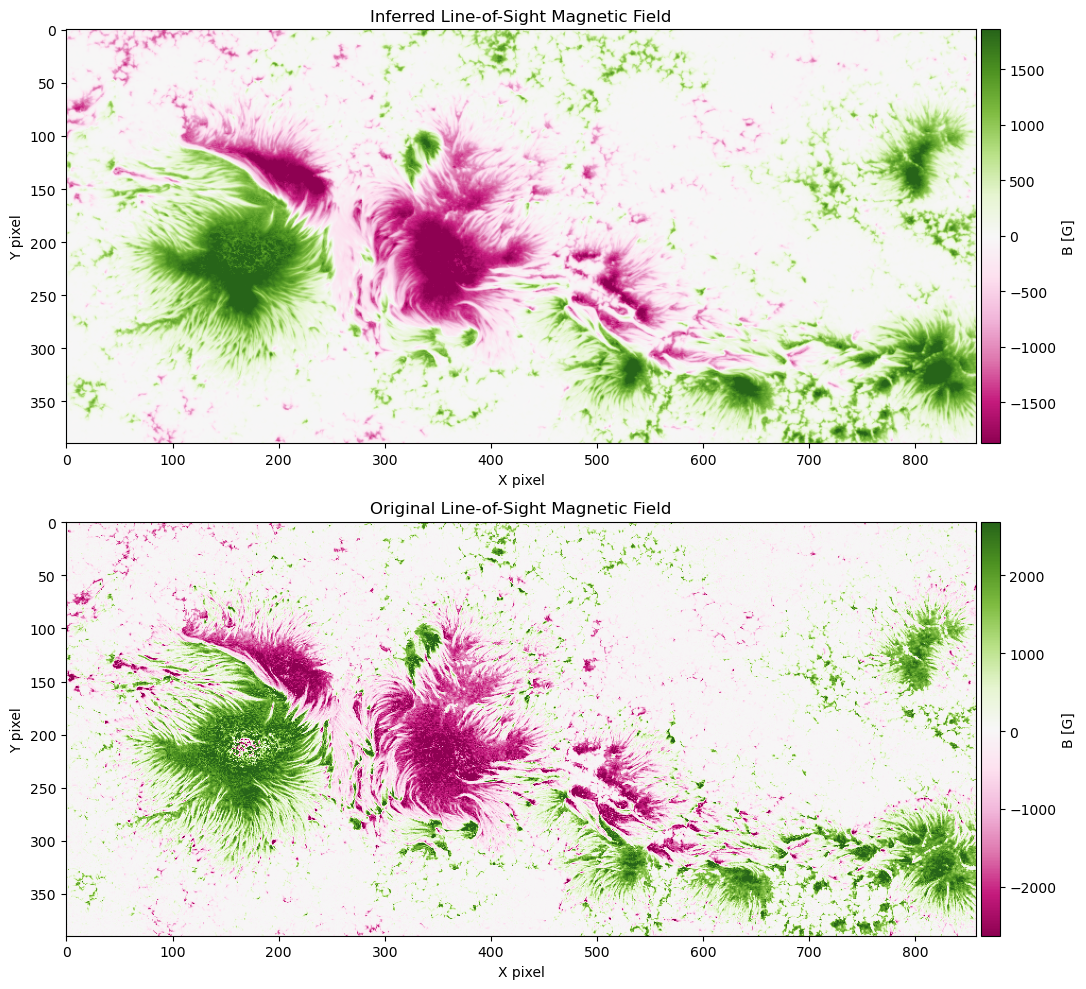

In [14]:

fig, ax = plt.subplots(2,figsize=(7*2, 10))
ims = []

vmin, vmax = np.quantile(inferred_B_LOS.value, [0.01, 0.99])
ims.append(ax[0].imshow(inferred_B_LOS.value, cmap='PiYG', vmin=vmin, vmax=vmax))

ax[0].set_title(f'Inferred Line-of-Sight Magnetic Field')
ax[0].set_xlabel('X pixel')
ax[0].set_ylabel('Y pixel')
ax[0].grid(False)

# Fix: Display Stokes V for all pixels at wavelength index 50
vmin, vmax = np.quantile(inverted_atm_B_LOS, [0.01, 0.99])
ims.append(ax[1].imshow(inverted_atm_B_LOS, cmap = "PiYG", vmin=vmin, vmax=vmax))
ax[1].set_title('Original Line-of-Sight Magnetic Field')
ax[1].set_xlabel('X pixel')
ax[1].set_ylabel('Y pixel')
ax[1].grid(False)

for i in range(2):
#     ax[i].set_xticks([])
#     ax[i].set_yticks([])

    # Create proper sized colorbar
    divider = make_axes_locatable(ax[i])
    cax = divider.append_axes("right", size="2%", pad=0.05)
    cbar = fig.colorbar(ims[i], cax=cax)
    cbar.set_label('B [G]')

plt.tight_layout()

In [15]:
# Define region boundaries as variables for easy modification
y_start, y_end = 50, 170
x_start, x_end = 550, 750

# Select the regions using the variables
qs_cont = continuun[y_start:y_end, x_start:x_end]
qs_wfa_BLOS = inferred_B_LOS[y_start:y_end, x_start:x_end].value
qs_orig_BLOS = inverted_atm_B_LOS[y_start:y_end, x_start:x_end]

# Display the shape
print(f"Region shape: {qs_wfa_BLOS.shape}")


Region shape: (120, 200)


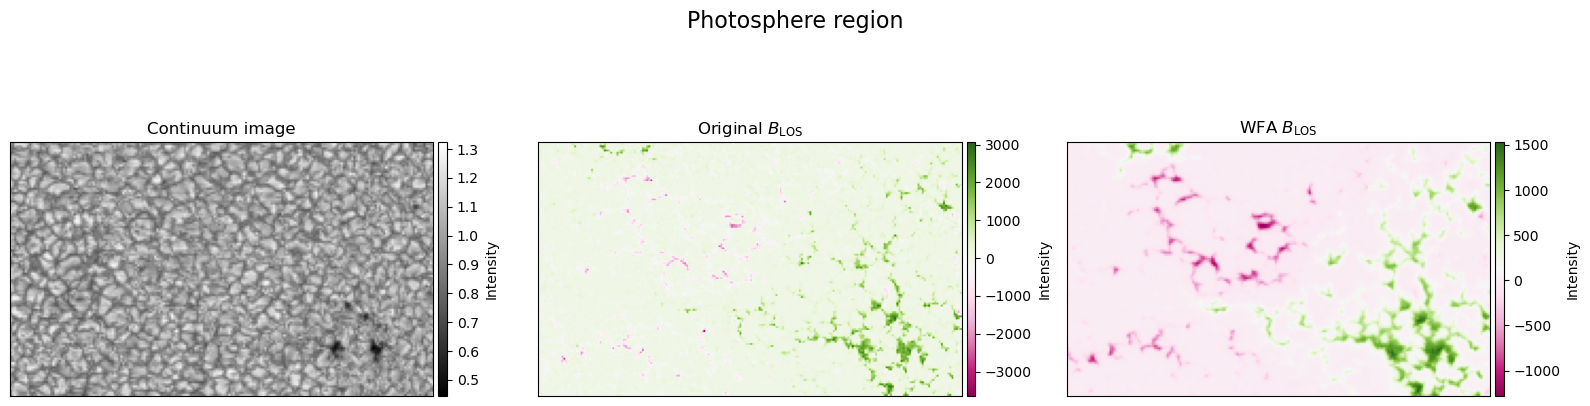

In [16]:
fig, ax = plt.subplots(1,3,figsize=(8*2,5))
# Set title for the entire figure
fig.suptitle(f'Photosphere region', fontsize=16)
ims = []
ims.append(ax[0].imshow(qs_cont, cmap='gray'))
ims.append(ax[1].imshow(qs_orig_BLOS, cmap='PiYG'))
ims.append(ax[2].imshow(qs_wfa_BLOS, cmap='PiYG'))
ax[0].set_title('Continuum image')
ax[1].set_title(r'Original $B_{\text{LOS}}$')
ax[2].set_title(r'WFA $B_{\text{LOS}}$')
for i in range(3):
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].grid(False)
    # Create proper sized colorbar
    divider = make_axes_locatable(ax[i])
    cax = divider.append_axes("right", size="2%", pad=0.05)
    cbar = fig.colorbar(ims[i], cax=cax)
    cbar.set_label('Intensity')
fig.tight_layout()

### Applying our own model

In [17]:
import sys
sys.path.append("../")
from modules.nn_models import InversionModel
scales = [1,2,4]
stokes_weights = [1,100,100,10]

In [18]:


los_model = InversionModel(scales=scales, 
                            nwl_points=stokes_data_original.shape[-1],
                            n_outputs=atm_data_original.shape[-1]*len(new_logtau)).to(device).float()
los_model.name = "only_LOS"

experiment_name = "Hinode_"+los_model.name
weights_name = f"{experiment_name}.pth"

print(f"Charging weights from {experiment_name}...")
charge_weights(model = los_model,
                target_dir = target_dir,
                wei

SyntaxError: incomplete input (431050952.py, line 12)

## Sergiy

In [ ]:
# snapshot_number = "080000"
# nx = 480
# ny = 480
# nlam = 300
# N_profs = 4
# sergiy_stokes = np.zeros((nx, ny, N_profs, nlam))
# for ix in tqdm(range(nx)):
#     for iy in range(ny):
#         pixel_profs = read_prof(f"../data/stokes/{snapshot_number}_0000_0000.prof", 'nicole',  nx, ny, nlam, iy, ix)
#         pixel_profs = np.moveaxis(pixel_profs, 0, -1)
#         sergiy_stokes[ix,iy,:,:] = pixel_profs
# sergiy_stokes[...,1:,:] = sergiy_stokes[...,1:,:] * 9

In [ ]:
# sergiy_stokes.shape

In [ ]:
# filename = "112000"
# #Charging original sergiy BLOS 
itau = 1
original_B_LOS = np.load(f"/scratchsan/observatorio/juagudeloo/data/opt_depth/mbzz_logtau_080000_3_nodes.npy")[...,itau]

# # Charging sergiy stokes
sergiy_stokes = np.moveaxis(np.load(f"/scratchsan/observatorio/juagudeloo/data/stokes/080000_prof.npy"), -2, -1)
# Multiplying by a factor of 10 to match the ideal difference between the stokes I and the Stokes V
sergiy_stokes[...,1:,:] = sergiy_stokes[...,1:,:]

# # Defining wavelengths array
wl = np.linspace(0,300,300)*0.01 + 6300.5
wl *= u.Angstrom

In [ ]:
# Mean value of the intensity on the continuum. Taking the 10 first values that correspond to the continuum.
I_c = sergiy_stokes[..., 0,0:10].mean(axis=-1).flatten().mean()

# Normalizing the Stokes profiles
sergiy_stokes /= I_c


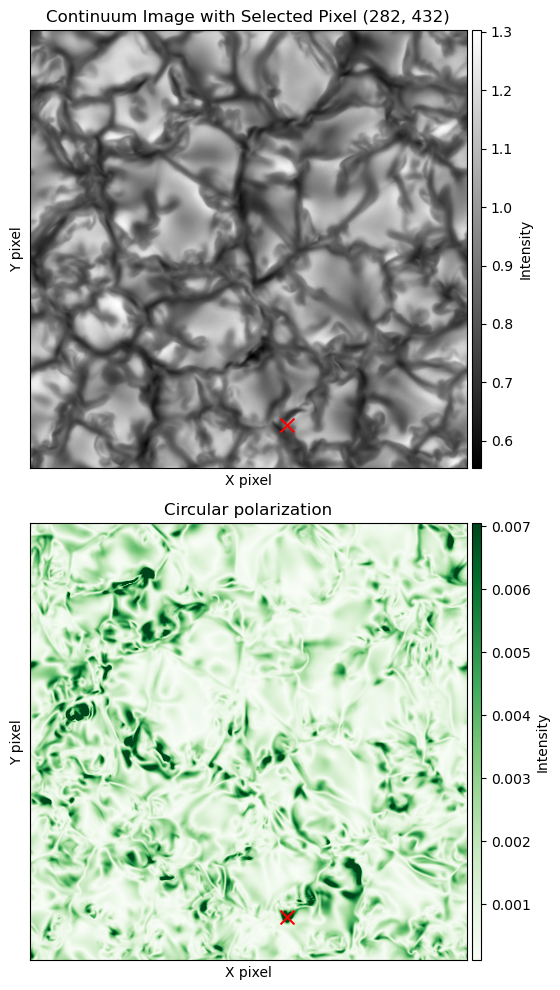

In [ ]:
pixel_y = 432
pixel_x = 282

fig, ax = plt.subplots(2, figsize=(18*2,10))
ims = []


continuum = sergiy_stokes[...,0,:].mean(axis=-1)
circular_polarization = np.sqrt(np.sum(sergiy_stokes[...,3,:]**2.0, axis = -1))

ims.append(ax[0].imshow(continuum, cmap='gray'))
for i in range(2):
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].scatter(pixel_x, pixel_y, color='red', marker='x', s=100)  # Mark the pixel
ax[0].set_title(f'Continuum Image with Selected Pixel ({pixel_x}, {pixel_y})')
ax[0].set_xlabel('X pixel')
ax[0].set_ylabel('Y pixel')
ax[0].grid(False)

# Fix: Display Stokes V for all pixels at wavelength index 50
vmin, vmax = np.quantile(circular_polarization, [0.01, 0.99])
ims.append(ax[1].imshow(circular_polarization, cmap='Greens', vmin=vmin, vmax=vmax))
ax[1].set_title('Circular polarization')
ax[1].set_xlabel('X pixel')
ax[1].set_ylabel('Y pixel')
ax[1].grid(False)

# Create proper sized colorbar
for i in range(2):
    divider = make_axes_locatable(ax[i])
    cax = divider.append_axes("right", size="2%", pad=0.05)
    cbar = fig.colorbar(ims[i], cax=cax)
    cbar.set_label('Intensity')

plt.tight_layout()

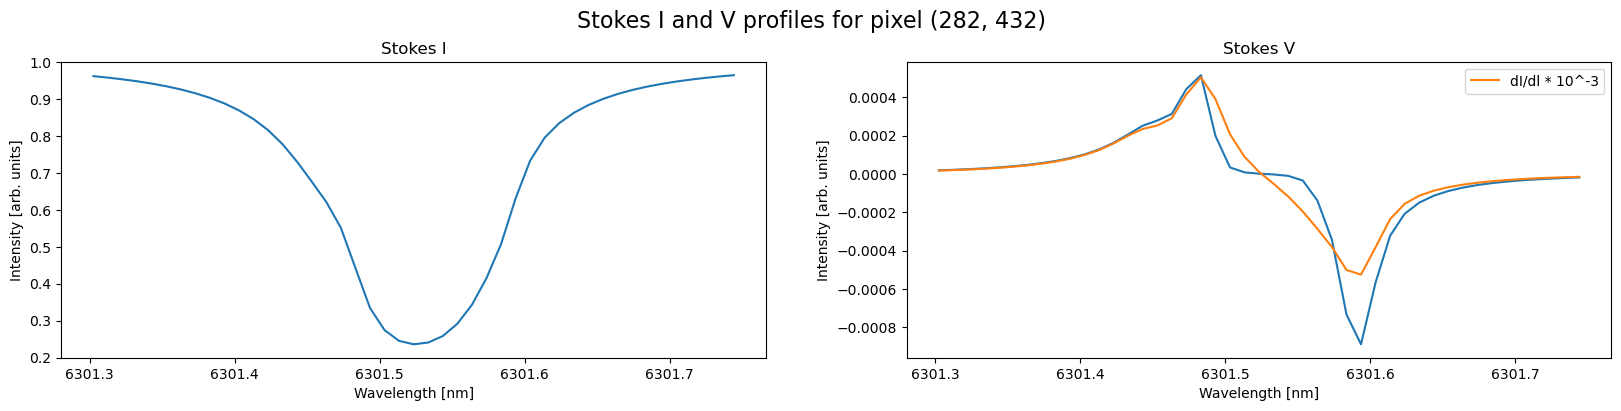

In [ ]:
start_wl = 80
end_wl = 125
scale_constant = -(4.69E-13)* 6301.5**2.0 * 1.67 * 1.5

fig, ax = plt.subplots(1,2,figsize=(10*2,4))
# Set title for the entire figure
fig.suptitle(f'Stokes I and V profiles for pixel ({pixel_x}, {pixel_y})', fontsize=16)

# Ensure non-scientific notation for x-axis ticks
for a in ax:
    a.ticklabel_format(useOffset=False, style='plain', axis='x')
    
# Add some padding for the suptitle
plt.subplots_adjust(top=0.85)
ax[0].plot(wl[start_wl:end_wl], sergiy_stokes[pixel_x, pixel_y,0,start_wl:end_wl])
ax[0].set_xlabel('Wavelength [nm]')
ax[0].set_ylabel('Intensity [arb. units]')
ax[0].set_title('Stokes I')
ax[1].plot(wl[start_wl:end_wl], sergiy_stokes[pixel_x, pixel_y,-1,start_wl:end_wl])
ax[1].set_xlabel('Wavelength [nm]')
ax[1].set_ylabel('Intensity [arb. units]')
ax[1].set_title('Stokes V')
dI_dl = np.gradient(sergiy_stokes[pixel_x, pixel_y,0,:]) / np.gradient(wl)
ax[1].plot(wl[start_wl:end_wl], dI_dl[start_wl:end_wl]*scale_constant, label='dI/dl * 10^-3')
ax[1].legend()
plt.show()

In [ ]:
np.gradient(wl)

<Quantity [0.01003344, 0.01003344, 0.01003344, 0.01003344, 0.01003344,
           0.01003344, 0.01003344, 0.01003344, 0.01003344, 0.01003344,
           0.01003344, 0.01003344, 0.01003344, 0.01003344, 0.01003344,
           0.01003344, 0.01003344, 0.01003344, 0.01003344, 0.01003344,
           0.01003344, 0.01003344, 0.01003344, 0.01003344, 0.01003344,
           0.01003344, 0.01003344, 0.01003344, 0.01003344, 0.01003344,
           0.01003344, 0.01003344, 0.01003344, 0.01003344, 0.01003344,
           0.01003344, 0.01003344, 0.01003344, 0.01003344, 0.01003344,
           0.01003344, 0.01003344, 0.01003344, 0.01003344, 0.01003344,
           0.01003344, 0.01003344, 0.01003344, 0.01003344, 0.01003344,
           0.01003344, 0.01003344, 0.01003344, 0.01003344, 0.01003344,
           0.01003344, 0.01003344, 0.01003344, 0.01003344, 0.01003344,
           0.01003344, 0.01003344, 0.01003344, 0.01003344, 0.01003344,
           0.01003344, 0.01003344, 0.01003344, 0.01003344, 0.01003344,
      

In [ ]:
inferred_sergiy_B_LOS = B_LOS_from_stokes(stokes = sergiy_stokes, 
                                   ll = wl, 
                                   start_ll = start_wl, 
                                   end_ll = end_wl, 
                                   llambda0 = 6301.5*u.Angstrom, 
                                   g = 1.67,
                                   stokes_v_index = 3)

ssim 0.16165295050944098


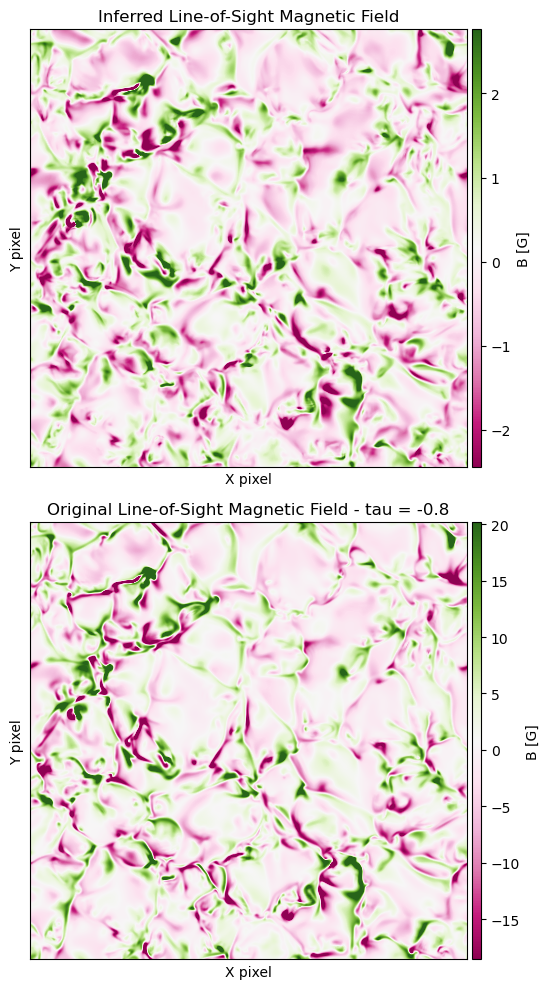

In [ ]:

fig, ax = plt.subplots(2,figsize=(7*2, 10))
ims = [] 

vmin, vmax = np.quantile(inferred_sergiy_B_LOS.value, [0.01, 0.99])
ims.append(ax[0].imshow(inferred_sergiy_B_LOS.value, cmap='PiYG', vmin=vmin, vmax=vmax))

ax[0].set_title(f'Inferred Line-of-Sight Magnetic Field')
ax[0].set_xlabel('X pixel')
ax[0].set_ylabel('Y pixel')
ax[0].grid(False)

# Fix: Display Stokes V for all pixels at wavelength index 50vmin, vmax = np.quantile(original_B_LOS, [0.01, 0.99])
logtau = np.array([-2.0, -0.8, 0])
vmin, vmax = np.quantile(original_B_LOS, [0.01, 0.99])
ims.append(ax[1].imshow(original_B_LOS, cmap = "PiYG", vmin = vmin, vmax = vmax))
ax[1].set_title(f'Original Line-of-Sight Magnetic Field - tau = {logtau[itau]}')
ax[1].set_xlabel('X pixel')
ax[1].set_ylabel('Y pixel')
ax[1].grid(False)


for i in range(2):
    ax[i].set_xticks([])
    ax[i].set_yticks([])

    # Create proper sized colorbar
    divider = make_axes_locatable(ax[i])
    cax = divider.append_axes("right", size="2%", pad=0.05)
    cbar = fig.colorbar(ims[i], cax=cax)
    cbar.set_label('B [G]')

plt.tight_layout()
print("ssim", ssim(original_B_LOS, inferred_sergiy_B_LOS.value, data_range=inferred_sergiy_B_LOS.value.max() - inferred_sergiy_B_LOS.value.min()))
plt.show()

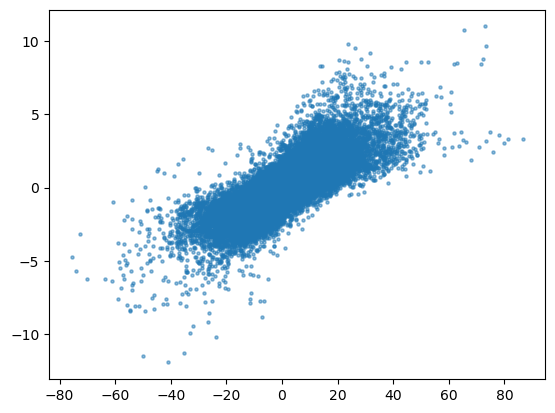

In [ ]:
plt.scatter(original_B_LOS.flatten(), inferred_sergiy_B_LOS.flatten(), s = 5, alpha = 0.5)

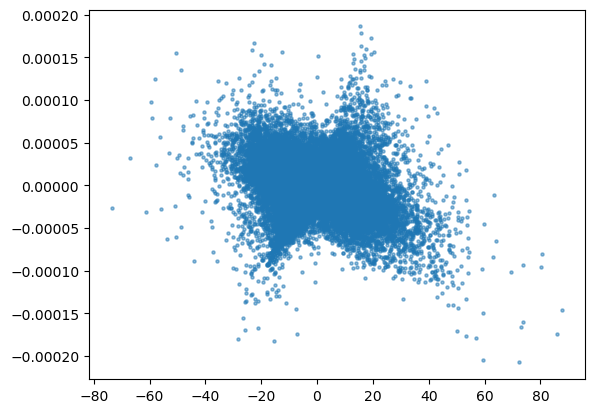

In [ ]:
plt.scatter(original_B_LOS.flatten(), sergiy_stokes[...,3,:].mean(axis=-1).flatten(), s = 5, alpha = 0.5)

In [ ]:
original_B_LOS.shape

(480, 480)

In [ ]:
root_mean_squared_error(original_B_LOS, inferred_B_LOS)

5.226736550193883

## MinMax

In [ ]:
def minmax(a):
    """
    Normalize the input array to the range [0, 1].
    
    Parameters:
    a : numpy.ndarray
        Input array to normalize.
        
    Returns:
    numpy.ndarray
        Normalized array.
    """
    a_min = np.min(a)
    a_max = np.max(a)
    return (a - a_min) / (a_max - a_min)

ssim 0.8773549877689673
rmse 0.06883726868701023


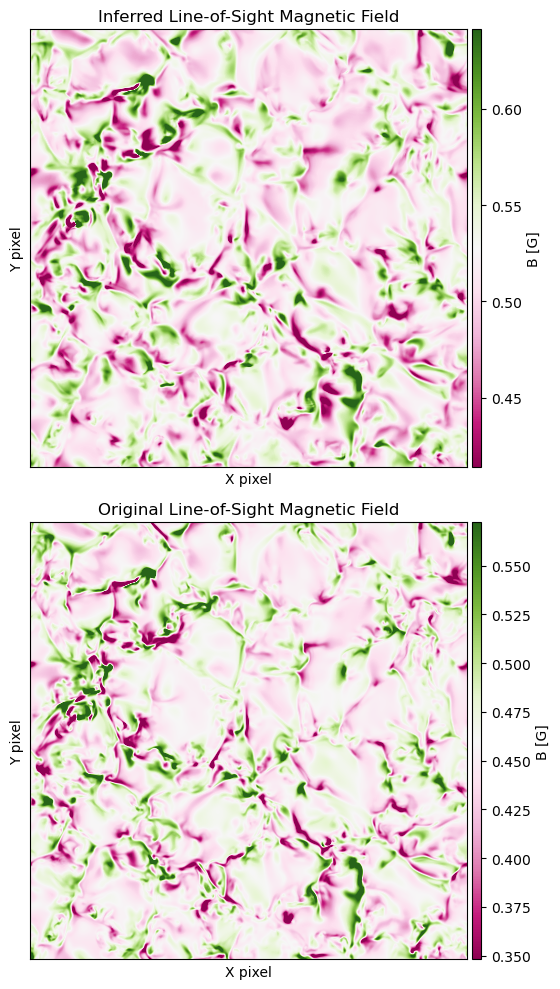

In [ ]:

fig, ax = plt.subplots(2,figsize=(7*2, 10))
ims = [] 

mm_inferred_B_LOS = minmax(inferred_sergiy_B_LOS.value)
mm_original_B_LOS = minmax(original_B_LOS)


vmin, vmax = np.quantile(mm_inferred_B_LOS, [0.01, 0.99])
ims.append(ax[0].imshow(mm_inferred_B_LOS, cmap='PiYG', vmin=vmin, vmax=vmax))

ax[0].set_title(f'Inferred Line-of-Sight Magnetic Field')
ax[0].set_xlabel('X pixel')
ax[0].set_ylabel('Y pixel')
ax[0].grid(False)

# Fix: Display Stokes V for all pixels at wavelength index 50vmin, vmax = np.quantile(original_B_LOS, [0.01, 0.99])

vmin, vmax = np.quantile(mm_original_B_LOS, [0.01, 0.99])
ims.append(ax[1].imshow(mm_original_B_LOS, cmap = "PiYG", vmin = vmin, vmax = vmax))
ax[1].set_title('Original Line-of-Sight Magnetic Field')
ax[1].set_xlabel('X pixel')
ax[1].set_ylabel('Y pixel')
ax[1].grid(False)

for i in range(2):
    ax[i].set_xticks([])
    ax[i].set_yticks([])

    # Create proper sized colorbar
    divider = make_axes_locatable(ax[i])
    cax = divider.append_axes("right", size="2%", pad=0.05)
    cbar = fig.colorbar(ims[i], cax=cax)
    cbar.set_label('B [G]')

plt.tight_layout()
print("ssim", ssim(mm_original_B_LOS, mm_inferred_B_LOS, data_range=mm_inferred_B_LOS.max() - mm_original_B_LOS.min()))
print("rmse", root_mean_squared_error(mm_original_B_LOS, mm_inferred_B_LOS))
plt.show()